In [1]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils.utils import load_dataset, download_dataset, create_cnn_model, get_callbacks, get_preds, show_train_loss_accuracy, show_metrics, INPUT_SHAPE, OUTPUT_CLASSES
%matplotlib inline
warnings.filterwarnings('ignore')

2025-10-06 23:33:21.451817: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-06 23:33:22.063401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exa

In [4]:
DATA_PATH = "./reclassified_augmented_dataset"
TEST_PATH = "./data_reclassified"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(TEST_PATH, "test")

In [5]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH)
X_test, y_test, _ = load_dataset(TEST_PATH)

X_train.shape, y_train.shape, LABEL_MAP

((44107, 48, 48, 3),
 (44107,),
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [6]:
# Resize images from 48x48 to 144x144
import cv2

X_train = np.array([cv2.resize(img, (144, 144)) for img in X_train])
X_test = np.array([cv2.resize(img, (144, 144)) for img in X_test])
X_train.shape, X_test.shape


((44107, 144, 144, 3), (7178, 144, 144, 3))

In [6]:
from tensorflow.keras.applications import VGG19, DenseNet201, ResNet50V2

OUTPUT_CLASSES = 7
INPUT_SHAPE = (144, 144, 3)


resnet50v2 = create_cnn_model(
    ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES, flatten=True)

denseNet201 = create_cnn_model(DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES, flatten=True)

vgg19 = create_cnn_model(VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=OUTPUT_CLASSES,
    classifier_activation="softmax"
), OUTPUT_CLASSES, flatten=True)

models = {
    "ResNet50v2": resnet50v2,
    "DenseNet201": denseNet201,
    "VGG19": vgg19,
    
}

2025-10-04 17:05:13.051985: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
from tensorflow.keras.utils import to_categorical

BATCH_SIZE = 32
EPOCHS = 60
histories = {}

# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=OUTPUT_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=OUTPUT_CLASSES)

for model_name, model in models.items():
    print(f"STRAT TRAINING MODEL {model_name}...")
    histories[model_name] = model.fit(X_train_resized, y_train_cat,
                                     validation_split=0.2,
                                     epochs=EPOCHS,
                                     batch_size=BATCH_SIZE,
                                     callbacks=get_callbacks(model_name))
    print(f"FINISH TRAINING MODEL {model_name}!")
    print("---------------------------------------------------------------")

STRAT TRAINING MODEL ResNet50v2...


2025-10-04 17:07:51.282562: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 8780037120 exceeds 10% of free system memory.


Epoch 1/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.3042 - loss: 2.2272

2025-10-04 17:17:15.193595: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2195195904 exceeds 10% of free system memory.


1103/1103 ━━━━━━━━━━━━━━━━━━━━ 630s 563ms/step - accuracy: 0.3587 - loss: 1.9864 - val_accuracy: 0.5148 - val_loss: 1.3355 - learning_rate: 1.0000e-04
Epoch 2/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 586s 532ms/step - accuracy: 0.4491 - loss: 1.5904 - val_accuracy: 0.5593 - val_loss: 1.1929 - learning_rate: 1.0000e-04
Epoch 3/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 583s 529ms/step - accuracy: 0.4937 - loss: 1.4170 - val_accuracy: 0.5876 - val_loss: 1.1229 - learning_rate: 1.0000e-04
Epoch 4/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 581s 527ms/step - accuracy: 0.5299 - loss: 1.2931 - val_accuracy: 0.6118 - val_loss: 1.0751 - learning_rate: 1.0000e-04
Epoch 5/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 586s 532ms/step - accuracy: 0.5521 - loss: 1.2184 - val_accuracy: 0.6240 - val_loss: 1.0322 - learning_rate: 1.0000e-04
Epoch 6/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 582s 528ms/step - accuracy: 0.5758 - loss: 1.1373 - val_accuracy: 0.6296 - val_loss: 1.0149 - learning_rate: 1.0000e-04
Epoch 7/60
1103/1103 ━━━━━━━━━━━━━━━━━━

2025-10-04 21:43:55.280452: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 8780037120 exceeds 10% of free system memory.


Epoch 1/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.2920 - loss: 2.2615

2025-10-04 22:00:39.105837: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2195195904 exceeds 10% of free system memory.


1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1134s 1s/step - accuracy: 0.3455 - loss: 2.0253 - val_accuracy: 0.4896 - val_loss: 1.4093 - learning_rate: 1.0000e-04
Epoch 2/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1051s 953ms/step - accuracy: 0.4247 - loss: 1.6689 - val_accuracy: 0.5158 - val_loss: 1.3114 - learning_rate: 1.0000e-04
Epoch 3/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1070s 970ms/step - accuracy: 0.4578 - loss: 1.5145 - val_accuracy: 0.5322 - val_loss: 1.2641 - learning_rate: 1.0000e-04
Epoch 4/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1074s 974ms/step - accuracy: 0.4833 - loss: 1.4317 - val_accuracy: 0.5376 - val_loss: 1.2274 - learning_rate: 1.0000e-04
Epoch 5/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1063s 964ms/step - accuracy: 0.5010 - loss: 1.3561 - val_accuracy: 0.5472 - val_loss: 1.2192 - learning_rate: 1.0000e-04
Epoch 6/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 1043s 946ms/step - accuracy: 0.5133 - loss: 1.3141 - val_accuracy: 0.5567 - val_loss: 1.2011 - learning_rate: 1.0000e-04
Epoch 7/60
1103/1103 ━━━━━━━━━━━━━━━

2025-10-05 09:55:55.809007: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 8780037120 exceeds 10% of free system memory.


Epoch 1/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2096s 2s/step - accuracy: 0.2797 - loss: 2.2045 - val_accuracy: 0.4142 - val_loss: 1.5691 - learning_rate: 1.0000e-04
Epoch 2/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2040s 2s/step - accuracy: 0.3361 - loss: 1.8813 - val_accuracy: 0.4372 - val_loss: 1.4922 - learning_rate: 1.0000e-04
Epoch 3/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2036s 2s/step - accuracy: 0.3588 - loss: 1.7582 - val_accuracy: 0.4460 - val_loss: 1.4847 - learning_rate: 1.0000e-04
Epoch 4/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2036s 2s/step - accuracy: 0.3792 - loss: 1.6760 - val_accuracy: 0.4643 - val_loss: 1.4348 - learning_rate: 1.0000e-04
Epoch 5/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2045s 2s/step - accuracy: 0.3926 - loss: 1.6156 - val_accuracy: 0.4706 - val_loss: 1.4188 - learning_rate: 1.0000e-04
Epoch 6/60
1103/1103 ━━━━━━━━━━━━━━━━━━━━ 2029s 2s/step - accuracy: 0.4075 - loss: 1.5676 - val_accuracy: 0.4730 - val_loss: 1.4015 - learning_rate: 1.0000e-04
Epoch 7/60
1103/1103 ━━━━━━━━━━━━━━━━━━━

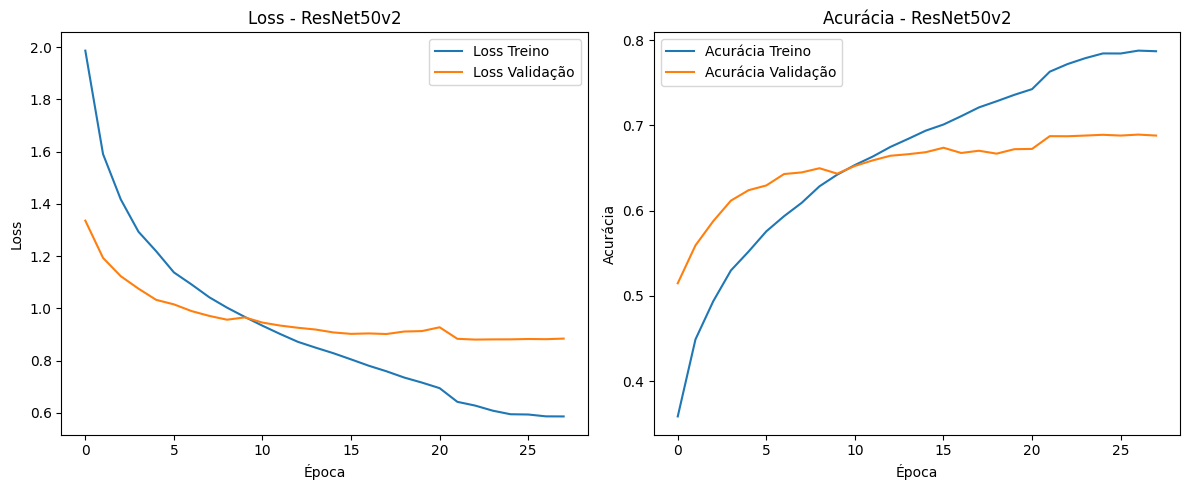

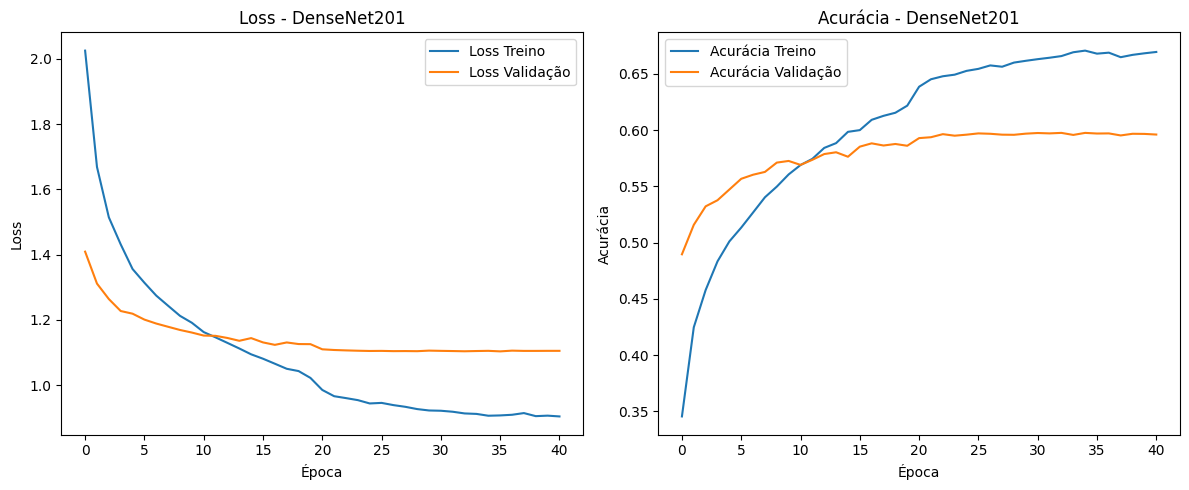

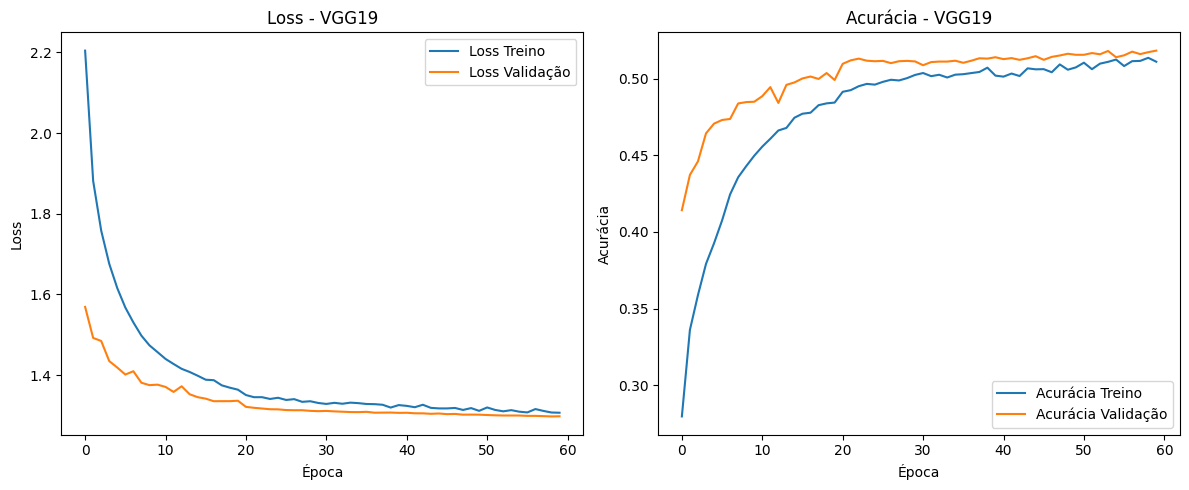

In [8]:
for model_name, history in histories.items():
    show_train_loss_accuracy(history, model_name)

In [2]:
#load models
from tensorflow.keras.models import load_model

resnet50v2 = load_model("ResNet50v2/best_ResNet50v2_model_basic.keras")
denseNet201 = load_model("DenseNet201/best_DenseNet201_model_basic.keras")
vgg19 = load_model("VGG19/best_VGG19_model_basic.keras")
models = {
    "ResNet50v2": resnet50v2,
    "DenseNet201": denseNet201,
    "VGG19": vgg19,
    
}


2025-10-06 23:33:38.473065: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
from tensorflow.keras.utils import to_categorical
y_preds = {}
# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=OUTPUT_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=OUTPUT_CLASSES)
for model_name, model in models.items():
    y_preds[model_name] = get_preds(X_train_resized, model)

2025-10-06 23:44:39.157495: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 10975233024 exceeds 10% of free system memory.


1379/1379 ━━━━━━━━━━━━━━━━━━━━ 606s 426ms/step


2025-10-07 00:00:43.090370: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 10975233024 exceeds 10% of free system memory.


1379/1379 ━━━━━━━━━━━━━━━━━━━━ 1089s 780ms/step


2025-10-07 00:21:12.325205: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 10975233024 exceeds 10% of free system memory.


1379/1379 ━━━━━━━━━━━━━━━━━━━━ 2076s 2s/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.8521
Precision Score:  0.8515
Recall Score:     0.8521
F1 Score:         0.8512

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      6301
           1       0.82      0.89      0.85      6301
           2       0.82      0.75      0.78      6301
           3       0.92      0.95      0.94      6301
           4       0.87      0.89      0.88      6301
           5       0.86      0.87      0.87      6301
           6       0.83      0.83      0.83      6301

    accuracy                           0.85     44107
   macro avg       0.85      0.85      0.85     44107
weighted avg       0.85      0.85      0.85     44107


Acurácia por classe:
- angry: 77.57%
- disgust: 89.03%
- fear: 75.16%
- happy: 95.24%
- neutral: 89.05%
- sad: 87.43%
- surprise: 83.00%


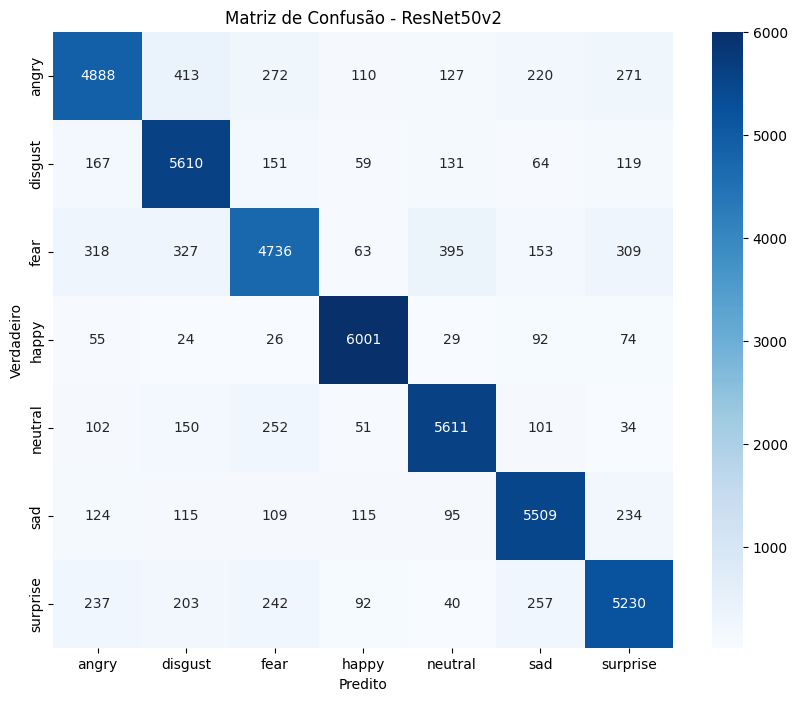

Métricas do modelo: DenseNet201
Accuracy Score:   0.7213
Precision Score:  0.7177
Recall Score:     0.7213
F1 Score:         0.7179

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.61      0.64      6301
           1       0.76      0.85      0.80      6301
           2       0.68      0.57      0.62      6301
           3       0.78      0.84      0.81      6301
           4       0.78      0.82      0.80      6301
           5       0.69      0.71      0.70      6301
           6       0.66      0.64      0.65      6301

    accuracy                           0.72     44107
   macro avg       0.72      0.72      0.72     44107
weighted avg       0.72      0.72      0.72     44107


Acurácia por classe:
- angry: 61.10%
- disgust: 85.38%
- fear: 56.77%
- happy: 84.30%
- neutral: 82.49%
- sad: 70.61%
- surprise: 64.26%


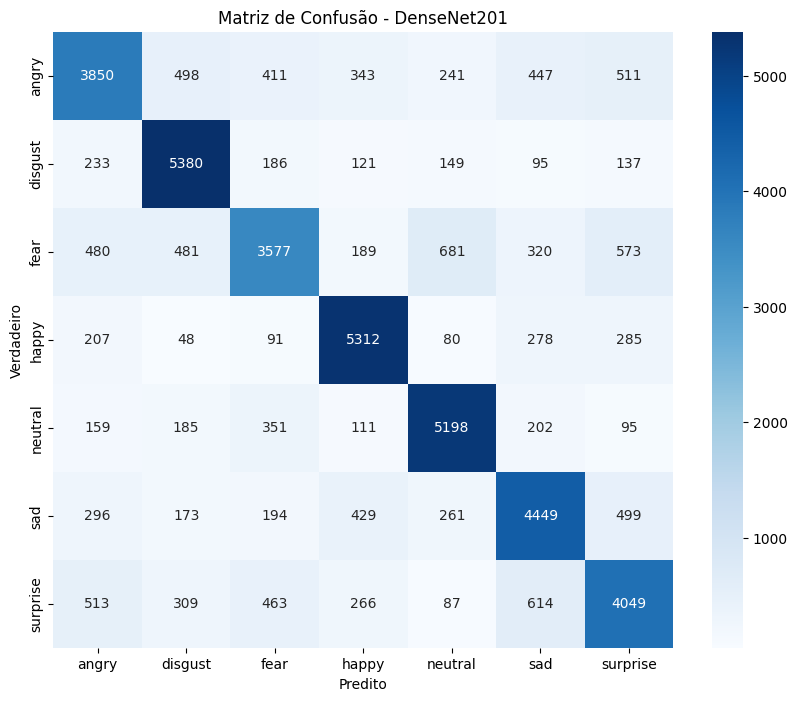

Métricas do modelo: VGG19
Accuracy Score:   0.5573
Precision Score:  0.5532
Recall Score:     0.5573
F1 Score:         0.545

Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.39      0.44      6301
           1       0.54      0.73      0.62      6301
           2       0.55      0.30      0.39      6301
           3       0.61      0.75      0.67      6301
           4       0.63      0.73      0.68      6301
           5       0.55      0.53      0.54      6301
           6       0.47      0.48      0.48      6301

    accuracy                           0.56     44107
   macro avg       0.55      0.56      0.54     44107
weighted avg       0.55      0.56      0.54     44107


Acurácia por classe:
- angry: 38.82%
- disgust: 72.67%
- fear: 29.60%
- happy: 74.67%
- neutral: 73.16%
- sad: 52.99%
- surprise: 48.21%


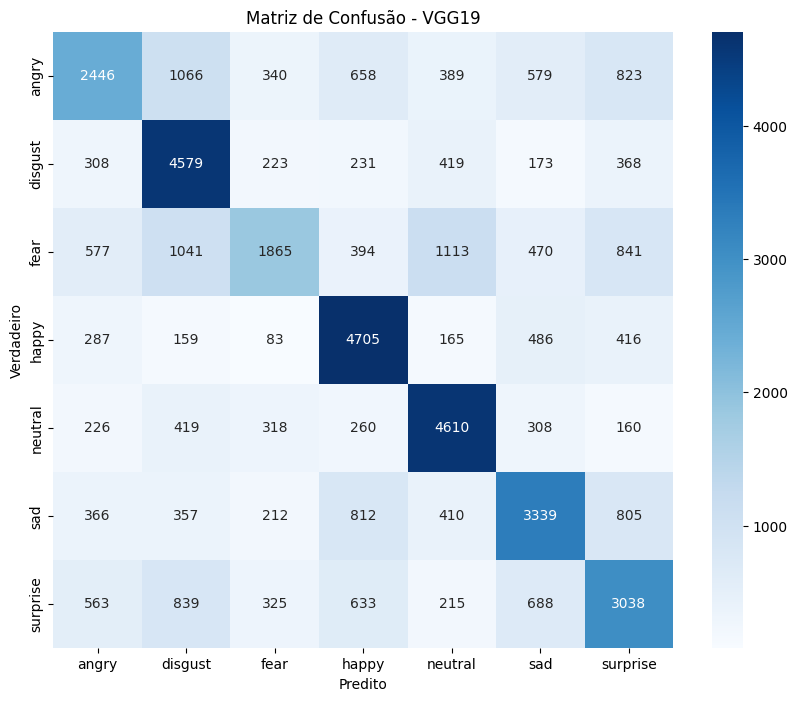

In [8]:
metrics = {}
for model_name, preds in y_preds.items():
    metrics[model_name] = show_metrics(y_train, preds, model_name, "confusion_matrix_completa_flatten", LABEL_MAP)

In [9]:
y_preds_teste = {}
for model_name, model in models.items():
    y_preds_teste[model_name] = get_preds(X_test_resized, model)

2025-10-07 00:57:11.466143: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1786116096 exceeds 10% of free system memory.


225/225 ━━━━━━━━━━━━━━━━━━━━ 94s 409ms/step


2025-10-07 00:58:46.915150: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1786116096 exceeds 10% of free system memory.


225/225 ━━━━━━━━━━━━━━━━━━━━ 169s 740ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step


Métricas do modelo: ResNet50v2
Accuracy Score:   0.5279
Precision Score:  0.4827
Recall Score:     0.512
F1 Score:         0.4896

Classification Report:

              precision    recall  f1-score   support

           0       0.43      0.43      0.43       958
           1       0.24      0.48      0.32       111
           2       0.40      0.30      0.35      1024
           3       0.77      0.67      0.72      1774
           4       0.65      0.70      0.67       831
           5       0.47      0.55      0.51      1233
           6       0.42      0.45      0.44      1247

    accuracy                           0.53      7178
   macro avg       0.48      0.51      0.49      7178
weighted avg       0.54      0.53      0.53      7178


Acurácia por classe:
- angry: 42.90%
- disgust: 47.75%
- fear: 30.47%
- happy: 67.02%
- neutral: 70.16%
- sad: 54.83%
- surprise: 45.31%


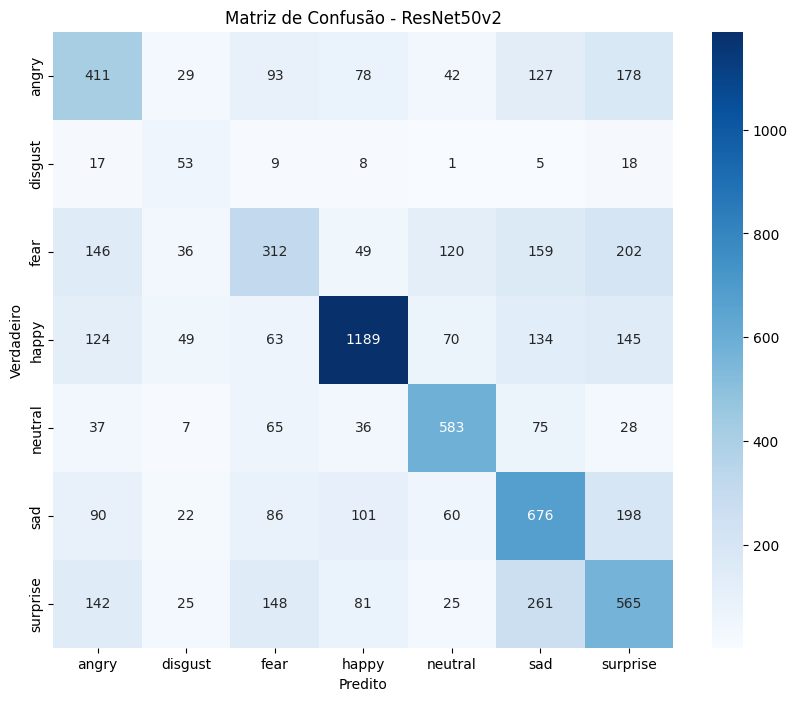

Métricas do modelo: DenseNet201
Accuracy Score:   0.5256
Precision Score:  0.4773
Recall Score:     0.494
F1 Score:         0.4808

Classification Report:

              precision    recall  f1-score   support

           0       0.43      0.44      0.43       958
           1       0.23      0.36      0.28       111
           2       0.42      0.29      0.34      1024
           3       0.74      0.67      0.70      1774
           4       0.63      0.69      0.66       831
           5       0.46      0.56      0.51      1233
           6       0.43      0.45      0.44      1247

    accuracy                           0.53      7178
   macro avg       0.48      0.49      0.48      7178
weighted avg       0.53      0.53      0.52      7178


Acurácia por classe:
- angry: 43.63%
- disgust: 36.04%
- fear: 28.71%
- happy: 67.31%
- neutral: 68.83%
- sad: 56.20%
- surprise: 45.07%


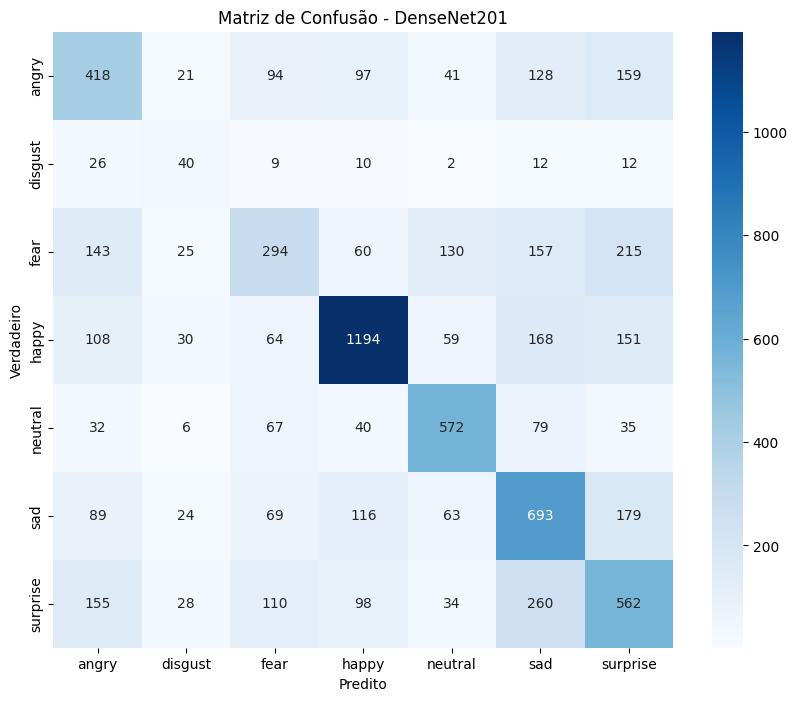

Métricas do modelo: VGG19
Accuracy Score:   0.4705
Precision Score:  0.415
Recall Score:     0.4297
F1 Score:         0.4096

Classification Report:

              precision    recall  f1-score   support

           0       0.40      0.36      0.38       958
           1       0.09      0.26      0.14       111
           2       0.40      0.18      0.25      1024
           3       0.63      0.66      0.64      1774
           4       0.58      0.66      0.62       831
           5       0.43      0.50      0.46      1233
           6       0.37      0.39      0.38      1247

    accuracy                           0.47      7178
   macro avg       0.41      0.43      0.41      7178
weighted avg       0.47      0.47      0.46      7178


Acurácia por classe:
- angry: 36.22%
- disgust: 26.13%
- fear: 17.68%
- happy: 66.07%
- neutral: 65.82%
- sad: 49.64%
- surprise: 39.21%


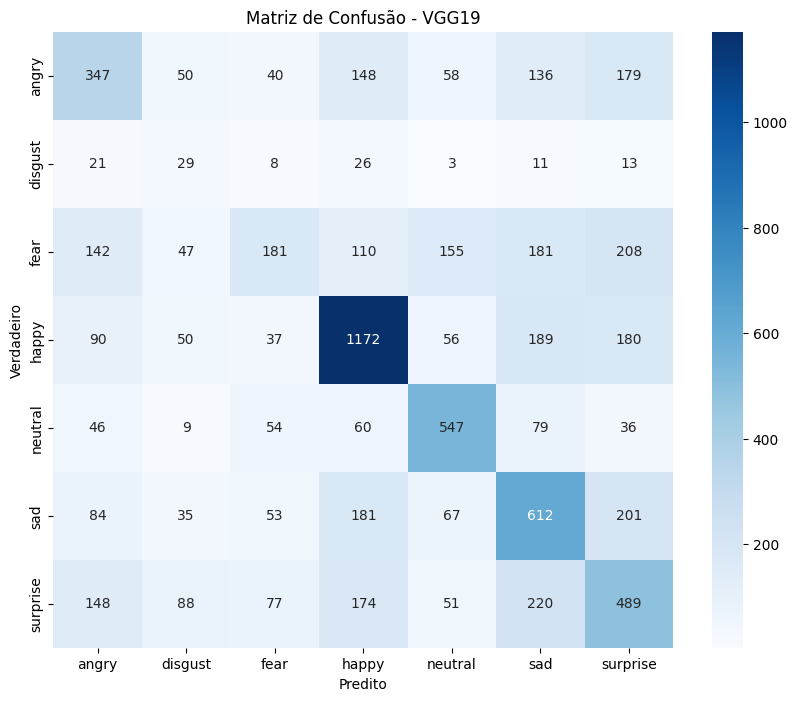

In [10]:
metrics_teste = {}
for model_name, preds in y_preds_teste.items():
    metrics_teste[model_name] = show_metrics(y_test, preds, model_name,"confusion_matrix_completa_flatten", LABEL_MAP, is_test=True)